In [39]:
import pandas as pd
from pandasql import sqldf
import boto3
import json
import os
# python -m spacy download en
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from keras import models, layers
# from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import LabelBinarizer
# import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
import matplotlib.pyplot as plt
import copy
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
%run '../extra_fns.ipynb'


In [2]:
with open('../boto-config.json') as json_data:
    boto_config = json.load(json_data)
    
s3 = boto3.client(
    's3',
    aws_access_key_id=boto_config['aws_access_key_id'],
    aws_secret_access_key=boto_config['aws_secret_access_key']
)

In [51]:
model_dir = 'trained_models'
try:
    os.makedirs(model_dir)
except Exception as e:
    print(e)

In [3]:
data_dir = 'data'
embedding_dir = 'embeddings'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
src_file = data_dir + '/News_Category_Dataset.json'
src_file_cleaned = data_dir + '/News_Clean.csv'

# s3.upload_file(src_file, boto_config['buckets']['kaggle'], src_file)
# s3.upload_file(src_file_cleaned, boto_config['buckets']['kaggle'], src_file_cleaned)

# s3.download_file(boto_config['buckets']['kaggle'], src_file, src_file)
# s3.download_file(boto_config['buckets']['kaggle'], src_file_cleaned, src_file_cleaned)

In [4]:
df = pd.read_json(src_file, lines=True)
# df = pd.read_csv(src_file_cleaned)
# df = df[~df.clean_text.isnull()]

In [5]:
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [6]:
df['text'] = df['headline'] + ' ' + df['short_description']

In [7]:
categories = np.array(df.category)

In [8]:
lbler = LabelEncoder()

In [9]:
labels = lbler.fit_transform(categories)

# Tokenization

In [12]:
max_dict_words = 10000
max_seq_words = 60

In [13]:
tokenizer = Tokenizer(num_words = max_dict_words)

In [14]:
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])

data = pad_sequences(sequences, maxlen=max_seq_words)

In [15]:
word_index = tokenizer.word_index

In [23]:
indices = np.arange(data.shape[0])

np.random.shuffle(indices)

In [24]:
data = data[indices]
labels = labels[indices]

In [45]:
num_labels = len(set(labels))

In [25]:
train_size = 0.7
val_size = 0.1
test_size = 1-train_size-val_size

In [26]:
training_samples = int(data.shape[0]*train_size)
val_samples = int(data.shape[0]*val_size)
test_samples = data.shape[0]-training_samples-val_samples

In [63]:
X_train = data[:training_samples]
y_train = to_categorical(labels[:training_samples])

X_val = data[training_samples:training_samples+val_samples]
y_val = to_categorical(labels[training_samples:training_samples+val_samples])

X_test = data[training_samples+val_samples:]
y_test = to_categorical(labels[training_samples+val_samples:])

# Using pretrained word embeddings

## Glove
https://nlp.stanford.edu/projects/glove/

In [72]:
embedding_index = {}

f = open(os.path.join(embedding_dir, 'glove.6B.300d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
    
f.close()

In [73]:
embedding_dim = 300

embedding_matrix = np.zeros((max_dict_words, embedding_dim))
for word, i in word_index.items():
    if i < max_dict_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector        

In [74]:
model = Sequential()
model.add(Embedding(max_dict_words, embedding_dim, input_length=max_seq_words))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 300)           3000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 18000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               2304128   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 31)                2015      
Total params: 5,314,399
Trainable params: 5,314,399
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [76]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [77]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Train on 87492 samples, validate on 12498 samples
Epoch 1/10
87492/87492 [==============================] - 3s 40us/step - loss: 1.9995 - acc: 0.4475 - val_loss: 1.7688 - val_acc: 0.4975
Epoch 2/10
87492/87492 [==============================] - 4s 43us/step - loss: 1.3803 - acc: 0.5972 - val_loss: 1.8344 - val_acc: 0.4819
Epoch 3/10
87492/87492 [==============================] - 3s 40us/step - loss: 0.9767 - acc: 0.7067 - val_loss: 1.9870 - val_acc: 0.4926
Epoch 4/10
87492/87492 [==============================] - 4s 40us/step - loss: 0.6569 - acc: 0.8013 - val_loss: 2.3440 - val_acc: 0.4620
Epoch 5/10
87492/87492 [==============================] - 4s 40us/step - loss: 0.4213 - acc: 0.8729 - val_loss: 2.7917 - val_acc: 0.4727
Epoch 6/10
87492/87492 [==============================] - 4s 40us/step - loss: 0.2662 - acc: 0.9187 - val_loss: 3.3082 - val_acc: 0.4687
Epoch 7/10
87492/87492 [==============================] - 3s 39us/step - loss: 0.1772 - acc: 0.9456 - val_loss: 3.7338 - val_acc

In [78]:
model.save_weights(model_dir + '/100d-glove-embedding.h5')

Max Val Accuracy 0.49751960306019566 on Epoch 0


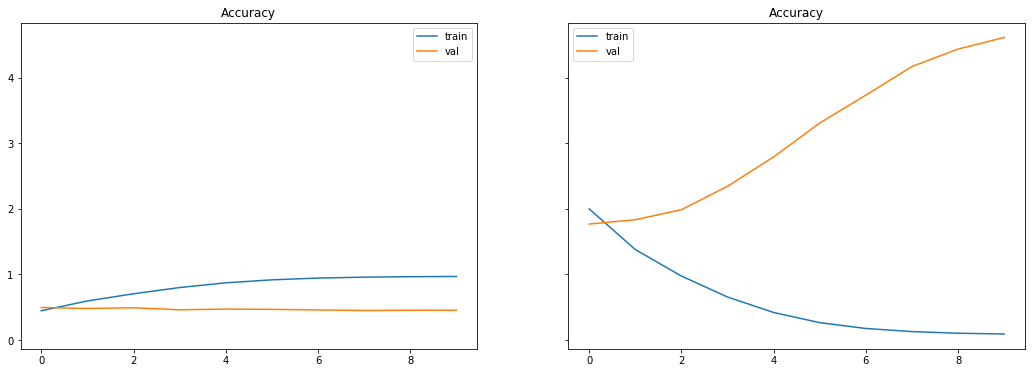

In [79]:
evaluate_nn(history)